In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)

In [6]:
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
        seqs.append(('ID%d'%counter,total_seq))
        counter += 1
    binary_skeleton = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
    binary_seq = binary_skeleton * n_motives
    return motives, seqs, binary_seq

In [7]:
from smod_wrapper import SMoDWrapper
from meme_wrapper import Meme
from sklearn.cluster import KMeans

In [8]:
def run_tool(motif_finder, scoring_criteria, pos_seqs, neg_seqs, 
             block_size, n_motives, min_motif_len, max_motif_len,
             complexity, min_score, min_freq, min_cluster_size,
             n_clusters, similarity_threshold, freq_threshold,p_value, 
             regex_th, sample_size, std_th):
    if motif_finder=='meme':
        with open('seqs.fa','w') as f_train:
            for seq in pos_seqs:
                f_train.write('>' + seq[0] + ' \n')
                f_train.write(seq[1] + '\n')

        tool =  Meme(alphabet='dna',
                     scoring_criteria = scoring_criteria,
                     minw=min_motif_len,
                     maxw=max_motif_len,
                     nmotifs=n_motives,
                     maxsize=1000000)
        tool.fit('seqs.fa')
    else:
        tool = SMoDWrapper(alphabet='dna',
                           scoring_criteria = scoring_criteria,
                           complexity = complexity,
                           n_clusters = n_clusters,
                           min_subarray_size = min_motif_len,
                           max_subarray_size = max_motif_len,
                           pos_block_size = block_size,
                           neg_block_size = block_size,
                           clusterer = KMeans(),
                           min_score = min_score,
                           min_freq = min_freq,
                           min_cluster_size = min_cluster_size,
                           similarity_th = similarity_threshold,
                           freq_th = freq_threshold,
                           p_value=p_value,
                           regex_th=regex_th,
                           sample_size=sample_size,
                           std_th=std_th)
        try:
            tool.fit(pos_seqs, neg_seqs)
        except:
            print
            print "No motives found by SMoD."
            tool = None
    return tool

def score_seqs(seqs, n_motives, tool):
    scores = []
    if tool is None:
        return scores
    
    for j in range(len(seqs)):
        seq_scr = []
        iters = tool.nmotifs
        for k in range(iters):
            scr=tool.score(motif_num=k+1, seq=seqs[j][1])
            seq_scr.append(scr)

        # taking average over all motives for a sequence
        if len(seq_scr) > 1:
            x = np.array(seq_scr[0])
            for l in range(1, iters):
                x = np.vstack((x, seq_scr[l]))
            seq_scr = list(np.mean(x, axis=0))
            scores.append(seq_scr)
        elif len(seq_scr) == 1:
            scores.append(np.array(seq_scr[0]))
        else:
            raise ValueError("no sequence score")
    return scores

In [9]:
import numpy as np
from sklearn.metrics import roc_auc_score
def evaluate(scoring_criteria='pwm', # ['pwm','hmm']
             motives=None,
             motif_length=6,
             n_motives=2,
             sequence_length=20,
             n_sequences=130,
             perturbation_prob=0.05,
             complexity=5,
             min_score=4,
             min_freq=0.25,
             min_cluster_size=5,
             n_clusters=15,
             min_subarray_size=5,
             max_subarray_size=10,
             similarity_threshold=.9,
             freq_threshold=None,
             p_value=0.05,
             regex_th=0.3,
             sample_size=200,
             std_th=None):

    motives, pos_seqs, binary_seq = make_artificial_dataset(alphabet='ACGT',
                                                            motives=motives,
                                                            sequence_length=sequence_length,
                                                            n_sequences=n_sequences,
                                                            motif_length=motif_length,
                                                            n_motives=n_motives,
                                                            p=perturbation_prob)
    
    from eden.modifier.seq import seq_to_seq, shuffle_modifier
    neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=1, order=2)
    neg_seqs = list(neg_seqs)

    block_size=n_sequences/8

    pos_size = len(pos_seqs)
    train_pos_seqs = pos_seqs[:pos_size/2]
    test_pos_seqs = pos_seqs[pos_size/2:]

    neg_size = len(neg_seqs)
    train_neg_seqs = neg_seqs[:neg_size/2]
    test_neg_seqs = neg_seqs[neg_size/2:]

    true_score = [float(int(i)) for i in binary_seq]

    tool_result = {'meme':[], 'smod':[]}
    for i in ['smod','meme']:
        tool = run_tool(motif_finder=i,
                        scoring_criteria = scoring_criteria,
                        pos_seqs=train_pos_seqs, 
                        neg_seqs=train_neg_seqs,
                        block_size=block_size,
                        n_motives=n_motives, 
                        complexity = complexity,
                        min_motif_len=min_subarray_size,
                        max_motif_len=max_subarray_size,
                        min_score=min_score,
                        min_freq=min_freq,
                        min_cluster_size=min_cluster_size,
                        n_clusters=n_clusters,
                        similarity_threshold=similarity_threshold,
                        freq_threshold=freq_threshold,
                        p_value=p_value,
                        regex_th=regex_th,
                        sample_size=sample_size,
                        std_th=std_th)
        
        scores = score_seqs(seqs=test_pos_seqs,
                            n_motives=n_motives,
                            tool=tool)
        
        if not scores:
            continue
        mean_score = np.mean(scores, axis=0)
        roc_score = roc_auc_score(true_score, mean_score)
        tool_result[i].append(roc_score)
    return tool_result

In [10]:
% matplotlib inline
import pylab as plt 

def plot_results(data, title='Experiment', xlabel='param', ylabel='values'):
    data_x =  np.array([param for param, val_m, std_m, val_s, std_s in data])
    data_y_m =  np.array([val_m for param, val_m, std_m, val_s, std_s in data])
    data_d_m =  np.array([val_m for param, val_m, std_m, val_s, std_s in data])
    data_y_s =  np.array([val_s for param, val_m, std_m, val_s, std_s in data])
    data_d_s =  np.array([val_s for param, val_m, std_m, val_s, std_s in data])
    
    plt.figure(figsize=(16,3))
    line_m, = plt.plot(data_x, data_y_m, lw=4, ls='-', color='cornflowerblue')
    plt.fill_between(data_x, data_y_m - data_d_m, data_y_m + data_d_m, alpha=0.1, color="b")
    plt.plot(data_x, data_y_m, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='cornflowerblue', markeredgewidth=3.0)
    line_s, = plt.plot(data_x, data_y_s, lw=4, ls='-', color='red')
    plt.fill_between(data_x, data_y_s - data_d_s, data_y_s + data_d_s, alpha=0.1, color="r")
    plt.plot(data_x, data_y_s, marker='o', color='w',linestyle='None',
                markersize=10, markeredgecolor='red', markeredgewidth=3.0)
    
    d=10.0
    plt.xlim([min(data_x)-(max(data_x) - min(data_x))/d, max(data_x)+(max(data_x) - min(data_x))/d])
    plt.ylim([0.5, 1])
    plt.suptitle(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend((line_m, line_s), ('MEME', 'SMoD'), loc=0)
    plt.grid()
    plt.show()

/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


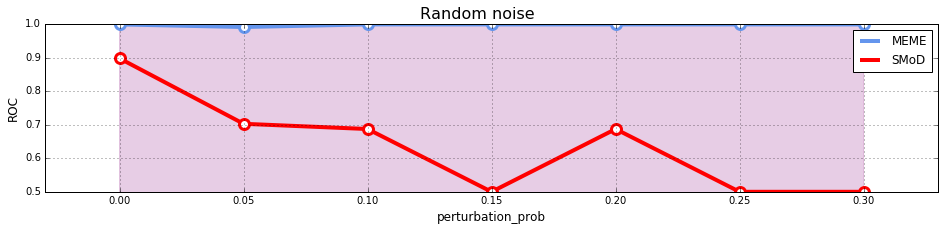

In [11]:

def make_results(n_rep=1):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=200,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=1,
                                   similarity_threshold=0.5,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=1,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

In [43]:
n_rep = 10

<h3> Experiments to find suitable parameters for SMoD </h3>

/home/zr/eden/EDeN/eden/sequence_motif_decomposer.py:48: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x - a) / b))


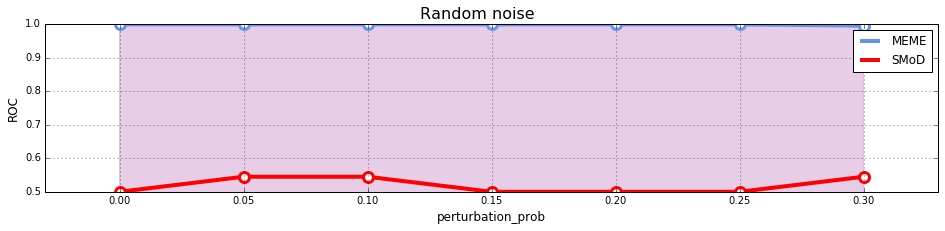

CPU times: user 4min 14s, sys: 12.8 s, total: 4min 27s
Wall time: 13min 7s


In [12]:
%%time


def make_results(n_rep=5):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=100,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.03,
                                   similarity_threshold=0.75,
                                   min_score=4,
                                   min_freq=0.5,
                                   min_cluster_size=10,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.03,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')


No motives found by SMoD.

No motives found by SMoD.

No motives found by SMoD.


/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/zr/anaconda2/envs/hiwi/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


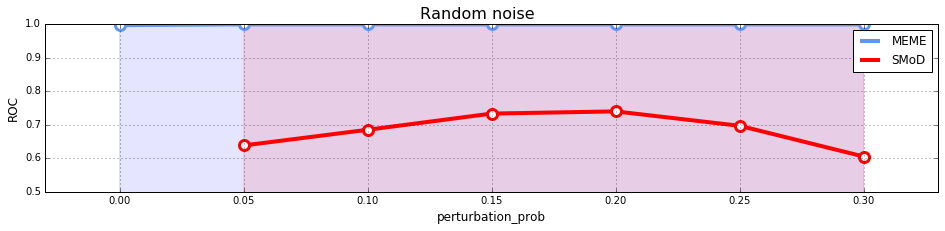

CPU times: user 2min 15s, sys: 7.22 s, total: 2min 22s
Wall time: 6min 39s


In [13]:
%%time


def make_results(n_rep=3):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=4,
                                   sequence_length=100,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=9,
                                   max_subarray_size=11,
                                   p_value=1,
                                   similarity_threshold=0.5,
                                   min_score=4,
                                   min_freq=0.5,
                                   min_cluster_size=2,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.03,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')


No motives found by SMoD.


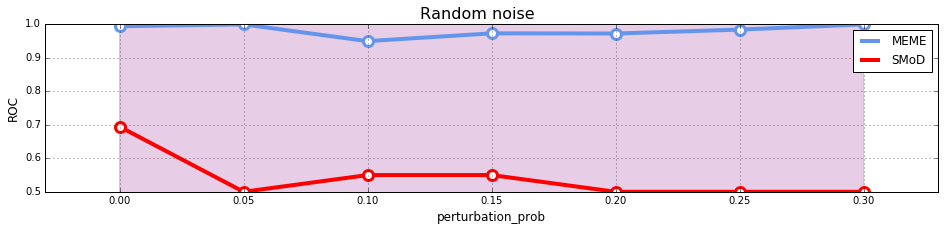

CPU times: user 2min 5s, sys: 6.76 s, total: 2min 12s
Wall time: 8min 23s


In [14]:
%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=3,
                                   sequence_length=60,
                                   n_sequences=600,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=1,
                                   similarity_threshold=0.5,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.03,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')


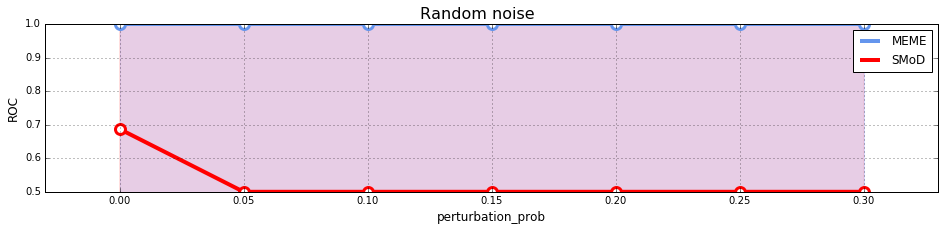

CPU times: user 1min 31s, sys: 8.82 s, total: 1min 39s
Wall time: 4min 32s
CPU times: user 1min 31s, sys: 8.82 s, total: 1min 39s
Wall time: 4min 33s


In [15]:

%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=1,
                                   similarity_threshold=0.5,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.5,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')



No motives found by SMoD.

No motives found by SMoD.

No motives found by SMoD.


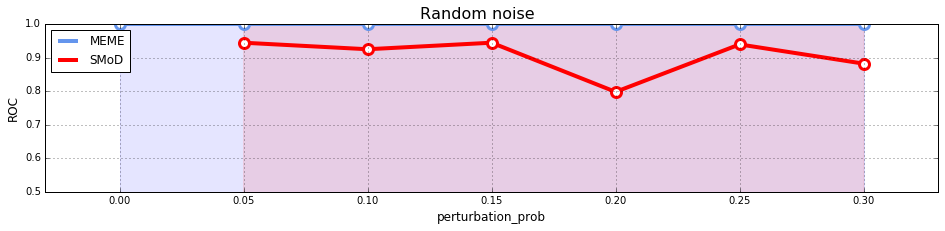

CPU times: user 1min 54s, sys: 7.04 s, total: 2min 1s
Wall time: 4min 44s


In [16]:

%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=10,
                                   min_subarray_size=8,
                                   max_subarray_size=12,
                                   p_value=1,
                                   similarity_threshold=1,
                                   min_score=5,
                                   min_freq=0.65,
                                   min_cluster_size=2,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=1,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

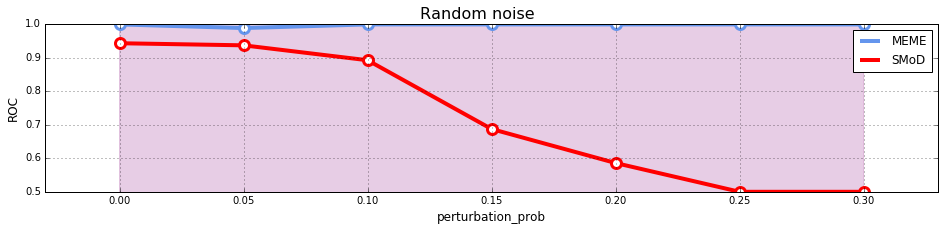

CPU times: user 1min 32s, sys: 9.43 s, total: 1min 42s
Wall time: 3min 3s


In [21]:

%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.3,
                                   similarity_threshold=0.9,
                                   min_score=4,
                                   min_freq=0.75,
                                   min_cluster_size=10,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.01,
                                   std_th=0.5)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')


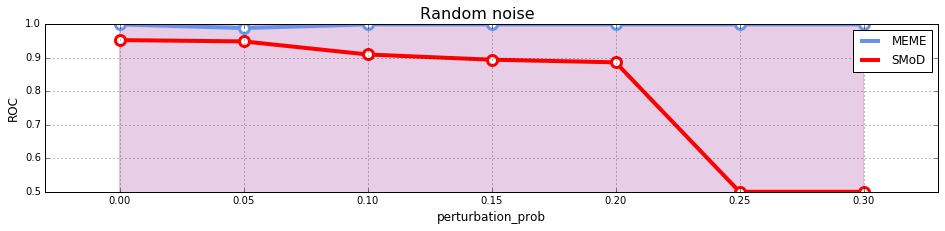

CPU times: user 1min 34s, sys: 9.46 s, total: 1min 43s
Wall time: 3min 5s


In [22]:

%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.03,
                                   similarity_threshold=0.9,
                                   min_score=4,
                                   min_freq=0.75,
                                   min_cluster_size=5,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.01,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

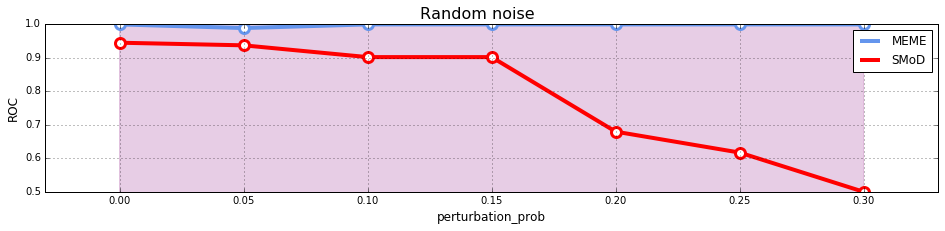

CPU times: user 1min 26s, sys: 9.01 s, total: 1min 35s
Wall time: 2min 44s


In [25]:

%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.03,
                                   similarity_threshold=0.9,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.01,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

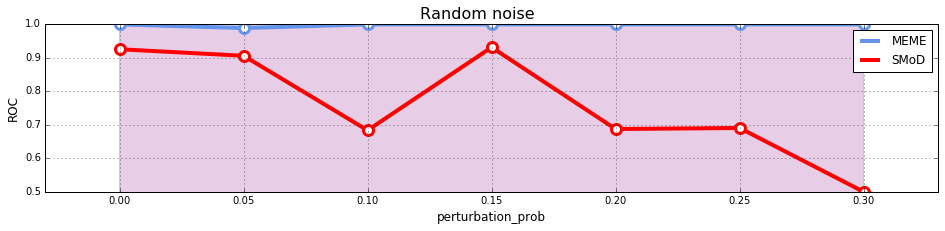

CPU times: user 1min 21s, sys: 8.92 s, total: 1min 30s
Wall time: 2min 42s


In [26]:
%%time

def make_results(n_rep=2):
    for param in [0.0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.03,
                                   similarity_threshold=0.9,
                                   min_score=4,
                                   min_freq=0.4,
                                   min_cluster_size=5,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.025,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

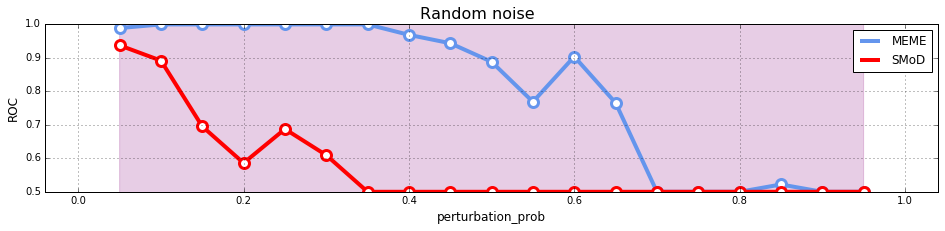

CPU times: user 3min 42s, sys: 25.7 s, total: 4min 8s
Wall time: 8min 11s


In [28]:

%%time

def make_results(n_rep=2):
    for param in [x/float(20) for x in range(1,20)]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=param,
                                   complexity=5,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   p_value=0.5,
                                   similarity_threshold=0.9,
                                   min_score=4,
                                   min_freq=0.25,
                                   min_cluster_size=5,
                                   regex_th=0.3,
                                   sample_size=200,
                                   freq_threshold=0.01,
                                   std_th=None)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            R = [r for r in results[tool] if r]
            avg = np.mean(R)
            std = np.std(R)
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]

data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

<h1>Experiment: Noise</h1>

<h2>with PWM</h2>

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 125 sites...
nsites = 125
Done initializing.
SEEDS: highwater mark: seq 124 pos 52

seqs=   125, min=  52, max=   52, total=     6500

motif=1
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites= 125, iter=   0 
motif=2
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites= 125, iter=   0 

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 125 sites...
nsites = 125
Done initializing.
SEEDS: highwater mark: seq 124 pos 52

seqs=   125, min=  52, max=   52, total=     6500

motif=1
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites= 125, iter=   0 
motif=2
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites= 125, iter=   0 

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to

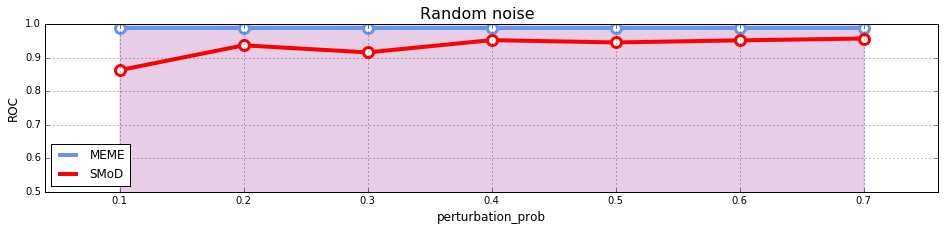

CPU times: user 6min 53s, sys: 45.3 s, total: 7min 38s
Wall time: 13min 5s


In [50]:
%%time

def make_results(n_rep=10):
    for param in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=0.05,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   min_score=4,
                                   min_freq=param,
                                   min_cluster_size=5,
                                   similarity_threshold=.90,
                                   freq_threshold=0.025,
                                   p_value=0.03)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

<h2>with HMM</h2>

original samples: 99
states: 11
sample size = 45
original samples: 88
states: 11
sample size = 45
original samples: 7
states: 7
No motives found by SMoD.
original samples: 125
states: 11
sample size = 45
original samples: 125
states: 10
sample size = 50
original samples: 104
states: 11
sample size = 45
original samples: 88
states: 11
sample size = 45
original samples: 125
states: 11
sample size = 45
original samples: 125
states: 10
sample size = 50
original samples: 98
states: 12
sample size = 41
original samples: 92
states: 11
sample size = 45
original samples: 125
states: 11
sample size = 45
original samples: 125
states: 10
sample size = 50


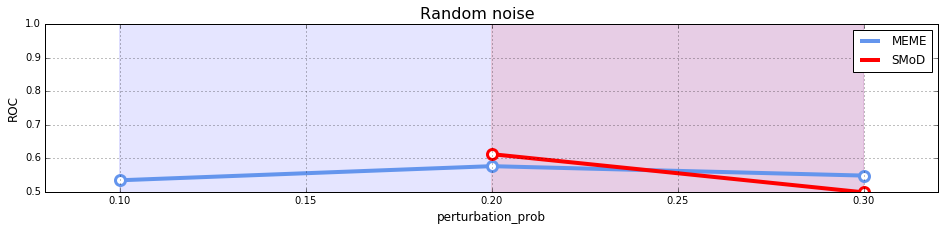

CPU times: user 4min 9s, sys: 2.04 s, total: 4min 11s
Wall time: 4min 27s


In [9]:
%%time

def make_results(n_rep=1):
    for param in [0.1,0.2,0.3]:#,0.4,0.5,0.6,0.7]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='hmm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=2,
                                   sequence_length=52,
                                   n_sequences=250,
                                   perturbation_prob=0.05,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   min_score=4,
                                   min_freq=param,
                                   min_cluster_size=5,
                                   similarity_threshold=.50,
                                   freq_threshold=0.025,
                                   p_value=0.03)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

<h1>Experiment: Number of Sequences</h1>

<h2>with PWM</h2>

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 49 pos 100

seqs=    50, min= 100, max=  100, total=     5000

motif=1
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 
motif=2
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 
motif=3
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 
motif=4
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 
motif=5
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 

INFO:meme_wrapper:The output directory 'meme_out' already exists.
Its contents will be overwritten.
Initializing the motif probability tables for 2 to 50 sites...
nsites = 50
Done initializing.
SEEDS: highwater mark: seq 49 pos 100

seqs=    50, min= 100, max=  100, total=     5000

motif=1
SEED WIDTHS: 5 7 9 12 15
em: w=  15, psites=  50, iter=   0 
motif=2
SEED WIDT

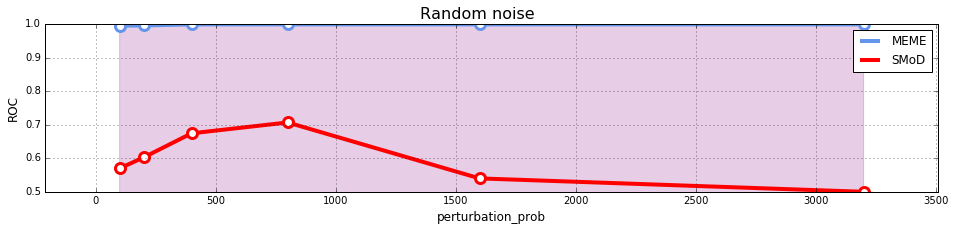

CPU times: user 10min 33s, sys: 12.8 s, total: 10min 46s
Wall time: 2h 45min 1s


In [51]:
%%time

def make_results(n_rep=2):
    for param in [100,200,400,800,1600,3200]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='pwm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=5,
                                   sequence_length=100,
                                   n_sequences=param,
                                   perturbation_prob=0.10,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   min_score=4,
                                   min_freq=0.4,
                                   min_cluster_size=5,
                                   similarity_threshold=.90,
                                   freq_threshold=0.025,
                                   p_value=0.03)

            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

<h2>with HMM</h2>

In [10]:
%%time

def make_results(n_rep=2):
    for param in [0.1,0.2,0.3]:
        results = {'meme':[], 'smod':[]}
        for rep in range(n_rep):
            tool_result = evaluate(scoring_criteria='hmm', # ['pwm','hmm']
                                   complexity=5,
                                   motif_length=10,
                                   n_motives=5,
                                   sequence_length=100,
                                   n_sequences=500,
                                   perturbation_prob=param,
                                   n_clusters=15,
                                   min_subarray_size=5,
                                   max_subarray_size=15,
                                   min_score=4,
                                   min_freq=0.4,
                                   min_cluster_size=5,
                                   similarity_threshold=.50,
                                   freq_threshold=0.025,
                                   p_value=1)
            
            results['meme'].append(tool_result['meme'])
            results['smod'].append(tool_result['smod'])
        for tool in ['meme', 'smod']:
            avg = np.mean(results[tool])
            std = np.std(results[tool])
            results[tool] = (avg, std)
        yield param, results['meme'][0], results['meme'][1], results['smod'][0], results['smod'][1]


data = [(param, val_m, std_m, val_s, std_s) for param, val_m, std_m, val_s, std_s in make_results()]
plot_results(data, title='Random noise', xlabel='perturbation_prob', ylabel='ROC')

original samples: 17
states: 9
No motives found by SMoD.
original samples: 249
states: 10
sample size = 50
original samples: 250
states: 10
sample size = 50


RuntimeError: HMM did not converge in 1000 iterations